In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from glob import glob
import numpy as np
import sys
sys.path.append('../../ifp')
sys.path.append('../../mcss')
sys.path.append('../../dock')
sys.path.append('../../score')
from containers import Protein

%matplotlib inline

In [2]:
fnames = [fname for fname in glob('../../../combind_data/bpp_data/*/ifp/raw/*.fp')]

In [3]:
def read_ifp(fname):
    ifp = []
    with open(fname) as fp:
        for line in fp:
            if line[:4] == 'Pose':
                ifp += [{}]
            else:
                i, r, d = line.split('-')
                d = eval(d[1:])
                i = int(i)
                ifp[-1][(i, r)] = d
    return ifp
data = {}
for i, fname in enumerate(fnames):
    if not i%100: print i
    protein = fname.split('/')[5]
    ligand = fname.split('/')[-1].split('-')[0]
    ifp = read_ifp(fname)
    if protein not in data: data[protein] = {}
    data[protein][ligand] = ifp

0
100
200
300
400
500
600


In [4]:
for protein, ligands in data.items():
    print protein
    prot = Protein(protein)
    lm = prot.lm
    prot.load_docking(ligands.keys(), False, False, False)
    for ligand, ifps in ligands.items():
        rmsds = [pose.rmsd for pose in prot.docking[lm.st].ligands[ligand].poses[:len(ifp)]]
        data[protein][ligand] = (ifps, rmsds)

P00489
5HT2B
PLK1
Q16539
MGLUR5
ERA
M3
P07900
GLUT1
P18031
P56817
O60885
MEK1
JAK2
P00742
DTRANSP
SIGMA1
P00734
P00760
B2AR
GCR
P24941
B1AR
VITD
A2AR
SMO
P03951
P00749
Q9Y233
CHK1
TRPV1
CDK2
AR
BRAF
MR
STRANSP


# Distributions

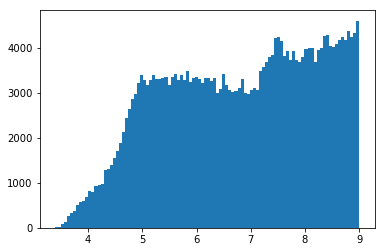

In [5]:
# PiPi
dists  = np.array([geom
                   for protein, ligands in data.items()
                   for ligand, (ifps, rmsds) in ligands.items()
                   for ifp in ifps
                   for key, geoms in ifp.items()
                   for geom in geoms
                   if key[0] == 6])

plt.hist(dists, bins = 100)
plt.show()

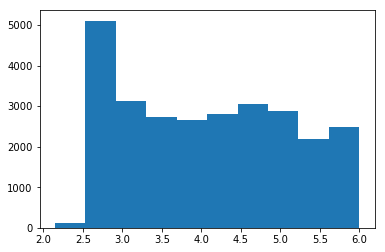

In [6]:
# Salt Bridges
dists  = np.array([geom
                   for protein, ligands in data.items()
                   for ligand, (ifps, rmsds) in ligands.items()
                   for ifp in ifps
                   for key, geoms in ifp.items()
                   for geom in geoms
                   if key[0] == 1])

plt.hist(dists)
plt.show()

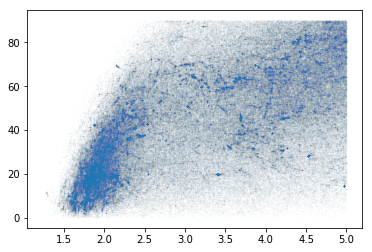

In [12]:
# hbonds
dists  = np.array([geom
                   for protein, ligands in data.items()
                   for ligand, (ifps, rmsds) in ligands.items()
                   for ifp in ifps
                   for key, geoms in ifp.items()
                   for geom in geoms
                   if key[0] in [2, 3]])

plt.scatter(dists[:, 0], dists[:, 1], s = 0.1, alpha = 0.03)
plt.show()

# Ligand seperation

In [22]:
def dist_score(dist, dist_opt, dist_cut):
    if dist <= dist_opt:
        return 1
    elif dist <= dist_cut:
        return ((dist_cut - dist)
                / (dist_cut - dist_opt))
    else:
        return 0
    
def angle_score(angle, angle_opt, angle_cut):
    if angle <= angle_opt:
        return 1
    elif angle <= angle_cut:
        return ((angle_cut - angle)
                / (angle_cut - angle_opt))
    else:
        return 0

#####

def hbond_score(fp, dist_opt, dist_cut, angle_opt, angle_cut):
    scored = {}
    for k, geoms in fp.items():
        if k[0] not in [2, 3]: continue
        scored[k] = 0
        for (dist, angle) in geoms:
            scored[k] += (  dist_score(dist, dist_opt, dist_cut)
                          * angle_score(angle, angle_opt, angle_cut))
    return scored

def pipi_score(fp, dist_opt, dist_cut, angle_opt, angle_cut):
    scored = {}
    for k, geoms in fp.items():
        if k[0] != 6: continue
        scored[k] = 0
        for dist in geoms:
            scored[k] += dist_score(dist, dist_opt, dist_cut)
    return scored

def sb_score(fp, dist_opt, dist_cut, angle_opt, angle_cut):
    scored = {}
    for k, geoms in fp.items():
        if k[0] != 6: continue
        scored[k] = 0
        for dist in geoms:
            scored[k] += dist_score(dist, dist_opt, dist_cut)
    return scored

#####

def get_ligand_aucs(dist_opt, dist_cut, angle_opt, angle_cut, scoring_fxn):
    aucs = []
    for protein, ligands in data.items():
        for ligand, (ifps, rmsds) in ligands.items()[:5]:
            overlaps = []
            correct = []
            for (scored, rmsd) in zip([scoring_fxn(ifp, dist_opt, dist_cut, angle_opt, angle_cut)
                                         for ifp in ifps], rmsds):
                overlaps += [sum(scored.values())]
                correct += [rmsd < 2.0 and rmsd < 2.0]
            if min(correct) != max(correct):
                aucs += [roc_auc_score(correct, overlaps)]
    return aucs

In [14]:
# PiPi
X_pipi = np.zeros((20, 20))
for i, dist_opt in enumerate(np.linspace(4, 9, 20)):
    for j, dist_cut in enumerate(np.linspace(4, 9, 20)):
        if dist_cut < dist_opt: continue
        X_pipi[i, j] = np.mean(get_ligand_aucs(dist_opt, dist_cut, 0, 0, pipi_score))

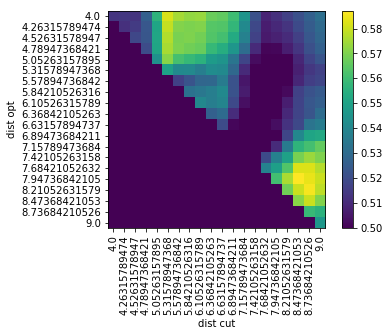

In [15]:
plt.imshow(X_pipi, vmin = 0.5)
plt.xticks(range(20), np.linspace(4, 9, 20), rotation = 'vertical')
plt.yticks(range(20), np.linspace(4, 9, 20))
plt.xlabel('dist cut')
plt.ylabel('dist opt')
plt.colorbar()
plt.show()

In [16]:
# sb
X_sb = np.zeros((20, 20))
for i, dist_opt in enumerate(np.linspace(2, 6, 20)):
    for j, dist_cut in enumerate(np.linspace(2, 6, 20)):
        if dist_cut < dist_opt: continue
        X_sb[i, j] = np.mean(get_ligand_aucs(dist_opt, dist_cut, 0, 0, sb_score))

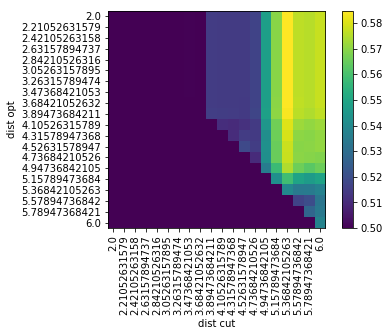

In [17]:
plt.imshow(X_sb, vmin = 0.5)
plt.xticks(range(20), np.linspace(2, 6, 20), rotation = 'vertical')
plt.yticks(range(20), np.linspace(2, 6, 20))
plt.xlabel('dist cut')
plt.ylabel('dist opt')
plt.colorbar()
plt.show()

In [23]:
# hbond
X_hbond = np.zeros((20, 20))
for i, dist_opt in enumerate(np.linspace(1, 5, 20)):
    for j, dist_cut in enumerate(np.linspace(1, 5, 20)):
        if dist_cut < dist_opt: continue
        X_hbond[i, j] = np.mean(get_ligand_aucs(dist_opt, dist_cut, 60.0, 90.0, hbond_score))

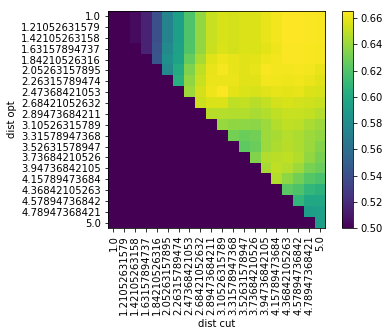

In [24]:
plt.imshow(X_hbond, vmin = 0.6)
plt.xticks(range(20), np.linspace(1, 5, 20), rotation = 'vertical')
plt.yticks(range(20), np.linspace(1, 5, 20))
plt.xlabel('dist cut')
plt.ylabel('dist opt')
plt.colorbar()
plt.show()

# Ligand Pair seperation

In [25]:
def overlap(scored1, scored2):
    score = 0
    for k in scored1:
        if k in scored2:
            score += np.sqrt(scored1[k] * scored2[k])
    return score
    
def get_ligand_pair_aucs(dist_opt, dist_cut, angle_opt, angle_cut, scoring_fxn):
    aucs = []
    for protein, ligands in data.items():
        for i, (ligand1, (ifps1, rmsds1)) in enumerate(ligands.items()[:5]):
            for ligand2, (ifps2, rmsds2) in ligands.items()[i+1:5]:
                overlaps = []
                correct = []
                for (scored1, rmsd1) in zip([scoring_fxn(ifp, dist_opt, dist_cut, angle_opt, angle_cut)
                                             for ifp in ifps1], rmsds1):
                    for (scored2, rmsd2) in zip([scoring_fxn(ifp, dist_opt, dist_cut, angle_opt, angle_cut)
                                                 for ifp in ifps2], rmsds2):
                        overlaps += [overlap(scored1, scored2)]
                        correct += [rmsd1 < 2.0 and rmsd2 < 2.0]
                if min(correct) != max(correct):
                    aucs += [roc_auc_score(correct, overlaps)]
    return aucs

In [27]:
# pipi pair
X_pair_pipi = np.zeros((5, 5))
for i, dist_opt in enumerate(np.linspace(4, 9, 5)):
    for j, dist_cut in enumerate(np.linspace(4, 9, 5)):
        if dist_cut < dist_opt: continue
        X_pair_pipi[i, j] = np.mean(get_ligand_pair_aucs(dist_opt, dist_cut, 0, 0, pipi_score))

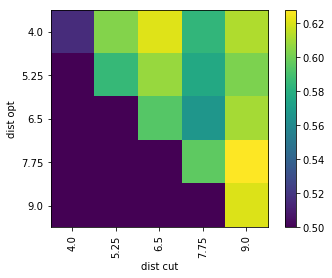

In [28]:
plt.imshow(X_pair_pipi, vmin = 0.5)
plt.xticks(range(5), np.linspace(4, 9, 5), rotation = 'vertical')
plt.yticks(range(5), np.linspace(4, 9, 5))
plt.xlabel('dist cut')
plt.ylabel('dist opt')
plt.colorbar()
plt.show()

In [29]:
# salt bridge pair
X_pair_sb = np.zeros((5, 5))
for i, dist_opt in enumerate(np.linspace(2, 6, 5)):
    for j, dist_cut in enumerate(np.linspace(2, 6, 5)):
        if dist_cut < dist_opt: continue
        X_pair_sb[i, j] = np.mean(get_ligand_pair_aucs(dist_opt, dist_cut, 0, 0, sb_score))

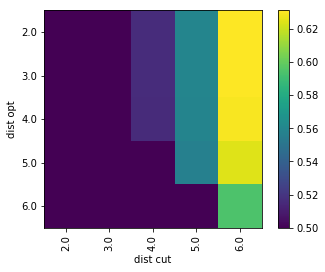

In [30]:
plt.imshow(X_pair_sb, vmin = 0.5)
plt.xticks(range(5), np.linspace(2, 6, 5), rotation = 'vertical')
plt.yticks(range(5), np.linspace(2, 6, 5))
plt.xlabel('dist cut')
plt.ylabel('dist opt')
plt.colorbar()
plt.show()

In [31]:
# hbond pair
X_pair_hbond = np.zeros((5, 5))
for i, dist_opt in enumerate(np.linspace(1, 5, 5)):
    for j, dist_cut in enumerate(np.linspace(1, 5, 5)):
        if dist_cut < dist_opt: continue
        X_pair_hbond[i, j] = np.mean(get_ligand_pair_aucs(dist_opt, dist_cut, 60.0, 90.0, hbond_score))

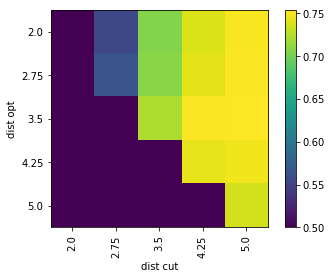

In [33]:
plt.imshow(X_pair_hbond, vmin = 0.5)
plt.xticks(range(5), np.linspace(2, 5, 5), rotation = 'vertical')
plt.yticks(range(5), np.linspace(2, 5, 5))
plt.xlabel('dist cut')
plt.ylabel('dist opt')
plt.colorbar()
plt.show()